In [1]:
import geopandas as gpd
import pandas as pd
import ee
import geemap
from geowrangler import grids
import matplotlib.pyplot as plt
from shapely.geometry import mapping

In [2]:
ee.Initialize()

In [3]:
geojson_path = 'Untitled_layer.geojson'
gdf = gpd.read_file(geojson_path)

In [4]:
grid_generator = grids.SquareGridGenerator(1_000)
grid_gdf = grid_generator.generate_grid(gdf)

In [5]:
Map = geemap.Map()
Map.add_gdf(gdf, layer_name='GeoJSON Layer', style={'color': 'red', 'fillOpacity': 0})
Map.add_gdf(grid_gdf, layer_name='1km x 1km Grid', style={'color': 'black', 'fillOpacity': 0.2})
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [6]:
geojson = gdf.__geo_interface__

In [8]:
roi = ee.Geometry(geojson['features'][0]['geometry'])
sent_5p = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_AER_AI')\
            .select('absorbing_aerosol_index') \
            .filterDate('2023-01-01', '2023-12-31')
start_date = '2023-11-01'
end_date = '2023-11-11'
sent5p_filtered = sent_5p.filterDate(start_date, end_date).filterBounds(roi)

In [9]:
def extract_values(image):
    date = ee.Date(image.get('system:time_start'))
    date_str = date.format('YYYY-MM-dd')
    time_str = date.format('HH:mm:ss')
    s5p = sent5p_filtered.filterDate(date, date.advance(1, 'day')).mean().reduceRegion(
        reducer=ee.Reducer.mean(), geometry=roi, scale=1000).get('absorbing_aerosol_index')
    
    return ee.Feature(None, {
        'date': date_str,
        'time': time_str,
        'sentinel5p': s5p
    })

features = sent5p_filtered.map(extract_values).getInfo()

In [10]:
values = []
for feature in features['features']:
    date = feature['properties']['date']
    time = feature['properties']['time']
    
    s5p = feature['properties'].get('sentinel5p', None)
    
    values.append({
        'date': date,
        'time': time,
        'coordinates': geojson['features'][0]['geometry']['coordinates'],
        'sentinel5p': s5p
    })

df = pd.DataFrame(values)
df.head(75)

,date,time,coordinates,sentinel5p
0,2023-11-01,07:47:03,"(((87.9199927, 23.1013063), (87.9749243, 22.20...",-0.508189
1,2023-11-01,07:52:03,"(((87.9199927, 23.1013063), (87.9749243, 22.20...",-0.719448
2,2023-11-02,07:32:02,"(((87.9199927, 23.1013063), (87.9749243, 22.20...",-0.923838
3,2023-11-03,07:12:02,"(((87.9199927, 23.1013063), (87.9749243, 22.20...",-1.028527
4,2023-11-04,06:52:03,"(((87.9199927, 23.1013063), (87.9749243, 22.20...",-0.326445
5,2023-11-05,06:32:02,"(((87.9199927, 23.1013063), (87.9749243, 22.20...",0.224975
6,2023-11-05,06:37:02,"(((87.9199927, 23.1013063), (87.9749243, 22.20...",0.450514
7,2023-11-05,08:12:03,"(((87.9199927, 23.1013063), (87.9749243, 22.20...",0.029941
8,2023-11-06,06:17:03,"(((87.9199927, 23.1013063), (87.9749243, 22.20...",0.029941
9,2023-11-06,07:57:02,"(((87.9199927, 23.1013063), (87.9749243, 22.20...",-0.041257


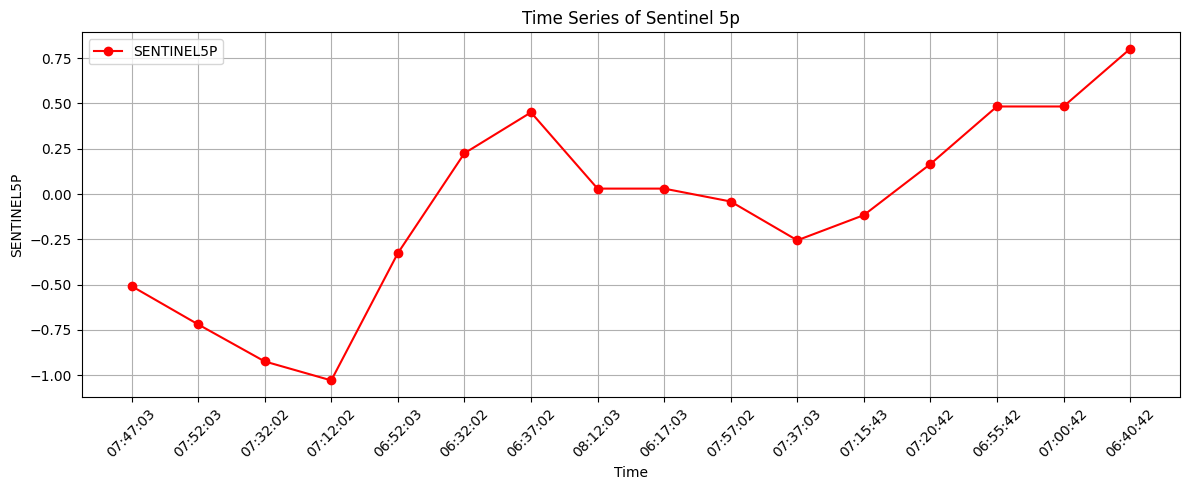

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(df['time'], df['sentinel5p'], marker='o', linestyle='-', color='red', label='SENTINEL5P')
plt.xlabel('Time')
plt.ylabel('SENTINEL5P')
plt.title('Time Series of Sentinel 5p')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

In [12]:
df.to_csv('SENTINEL_5P_DATA.csv')